In [30]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [31]:
working_dir = os.getcwd()

In [32]:
# Import solution
solution = pd.read_csv(f"{working_dir}/../data/Solution.csv")
X_true = pd.to_datetime(solution['TIMESTAMP'])

min_timestamp = X_true.min()
X_true = (X_true - min_timestamp).dt.total_seconds() / (24 * 60 * 60)
X_true = X_true.values.reshape(-1, 1)

Y_true = solution['POWER'].values.reshape(-1, 1)

In [33]:
# Import training data
train_data = pd.read_csv(f"{working_dir}/../data/TrainData.csv")
train_data = train_data.drop(columns=["U10", "V10", "WS10", "U100", "V100", "WS100"])
train_data['TIMESTAMP'] = pd.to_datetime(train_data['TIMESTAMP'])

min_timestamp = train_data['TIMESTAMP'].min()
train_data['TIMESTAMP'] = (train_data['TIMESTAMP'] - min_timestamp).dt.total_seconds() / (24 * 60 * 60)

# Variables for training timestamp and power
timestamp = train_data["TIMESTAMP"].values.reshape(-1, 1)
power = train_data["POWER"].values.reshape(-1, 1)

In [34]:
# Run Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(timestamp, power)

y_pred_lr = lin_reg.predict(X_true)
rmse_lr = np.sqrt(mean_squared_error(Y_true, y_pred_lr))

In [35]:
# Run SVR
svr = SVR()
svr.fit(timestamp, power)

y_pred_svr = svr.predict(X_true)
rmse_svr = np.sqrt(mean_squared_error(Y_true, y_pred_svr))

c:\Users\Simon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
## ANN

# Scaling the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
timestamp_scaled = scaler_x.fit_transform(timestamp)
power_scaled = scaler_y.fit_transform(power)
X_true_scaled = scaler_x.transform(X_true)

# ANN
# Define the ANN model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(timestamp_scaled, power_scaled, epochs=100, batch_size=32, verbose=0)

# Prediction using the ANN model
y_pred_scaled = model.predict(X_true_scaled)

# Inverse transform the predictions
y_pred_ann = scaler_y.inverse_transform(y_pred_scaled)

# Calculate RMSE
rmse_ann = np.sqrt(mean_squared_error(Y_true, y_pred_ann))

23/23 [==============================] - 0s 1ms/step


In [37]:
# Run RNN
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(timestamp_scaled, power_scaled, epochs=100, batch_size=32, verbose=0)

# Reshape X_true_scaled
X_true_scaled = X_true_scaled.reshape((X_true_scaled.shape[0], 1, X_true_scaled.shape[1]))

# Prediction using the RNN model
y_pred_scaled = model.predict(X_true_scaled)

# Inverse transform the predictions
y_pred_rnn = scaler_y.inverse_transform(y_pred_scaled)

# Calculate RMSE
rmse_rnn = np.sqrt(mean_squared_error(Y_true, y_pred_rnn))

23/23 [==============================] - 0s 1ms/step


In [38]:
# Evaluation of the test set models
print(f"{'RMSE for LR model:':<20}{rmse_lr}")
print(f"{'RMSE for SVR model:':<20}{rmse_svr}")
print(f"{'RMSE for ANN model:':<20}{rmse_ann}")
print(f"{'RMSE for RNN model:':<20}{rmse_rnn}")

RMSE for LR model:  0.2932364595947981
RMSE for SVR model: 0.30140353858538876
RMSE for ANN model: 0.2987170873748439
RMSE for RNN model: 0.2928346725163234


In [39]:
# Save to files
forecast_template = pd.read_csv(f'{working_dir}/../data/ForecastTemplate.csv')

# LR forecast template output
forecast_template['FORECAST'] = y_pred_lr
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-LR.csv', index=False)

# SVR forecast template
forecast_template['FORECAST'] = y_pred_svr
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-SVR.csv', index=False)

# ANN forecast template
forecast_template['FORECAST'] = y_pred_ann
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-ANN.csv', index=False)

# RNN forecast template
forecast_template['FORECAST'] = y_pred_rnn
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-RNN.csv', index=False)

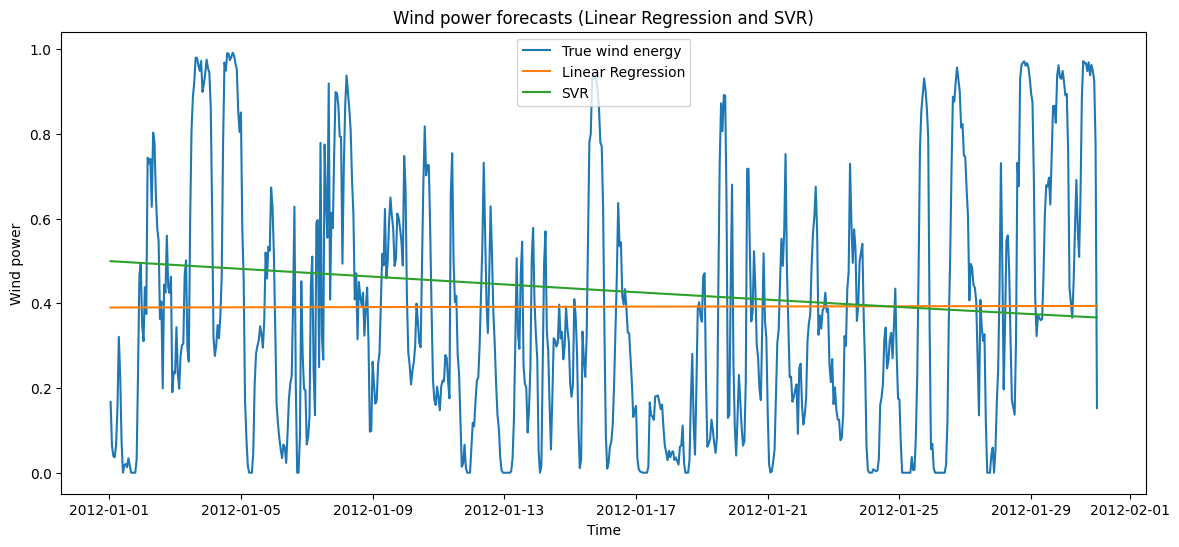

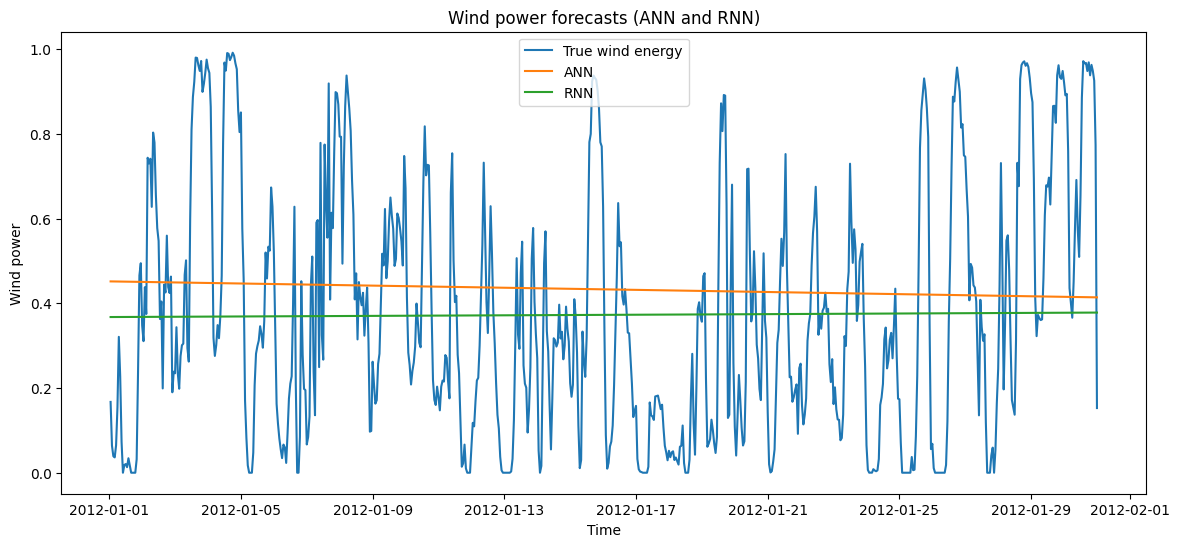

In [40]:
## Plot time-series

# Convert the TIMESTAMP back to datetime for plotting
X_true_datetime = pd.to_datetime(((X_true * (24 * 60 * 60)).astype(int)).flatten(), unit="s", origin=min_timestamp)

# Plot the time-series figure for Linear Regression and SVR
plt.figure(figsize=(14, 6))
plt.plot(X_true_datetime, Y_true, label="True wind energy")
plt.plot(X_true_datetime, y_pred_lr, label="Linear Regression")
plt.plot(X_true_datetime, y_pred_svr, label="SVR")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (Linear Regression and SVR)")
plt.legend()
plt.show()

# Plot the time-series figure for ANN and RNN
# Please replace y_pred_ann and y_pred_rnn with the predictions from the ANN and RNN models
plt.figure(figsize=(14, 6))
plt.plot(X_true_datetime, Y_true, label="True wind energy")
plt.plot(X_true_datetime, y_pred_ann, label="ANN")
plt.plot(X_true_datetime, y_pred_rnn, label="RNN")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (ANN and RNN)")
plt.legend()
plt.show()